In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import linear_sum_assignment
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from model_arch import CategoricalScoreDiffusion

In [3]:
# Load data
loaded_df = pd.read_hdf('./data/sample_otu_arrays.h5', key='df')

# Set random seed
np.random.seed(42)

# Split indices into train/test
train_idx, test_idx = train_test_split(loaded_df.index, test_size=0.2, random_state=42)

# Create train and test dataframes
train_df = loaded_df.loc[train_idx]
test_df = loaded_df.loc[test_idx]

In [5]:
checkpoint = torch.load(f"/mnt/mnemo9/mpelus/matlas/cdcd_multi_train/cdcd_hmp/artifacts/best_model_aiicxkad:v0/tmp21qdlph1.pt")
# Initialize model with the same parameters you showed
vocab_size = max(max(x) for x in loaded_df['otu_arrays']) + 1
embed_dim = 96
num_layers = 4
num_heads = 12
dim_feedforward = 28
num_fourier_features = 4

model = CategoricalScoreDiffusion(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    dim_feedforward=dim_feedforward,
    num_fourier_features=num_fourier_features
)


model.load_state_dict(checkpoint)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Move model to device
model = model.to(device)

/tmp/ipykernel_661316/3417690525.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"/mnt/mnemo9/mpelus/matlas/cdcd_multi_train/cdcd_hmp/artifacts/

In [28]:
vocab_size = max(max(x) for x in loaded_df['otu_arrays']) + 1
embed_dim = 96
num_layers = 4
num_heads = 12
dim_feedforward = 28
num_fourier_features = 4
model0 = CategoricalScoreDiffusion(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    dim_feedforward=dim_feedforward,
    num_fourier_features=num_fourier_features
)
checkpoint = torch.load('/mnt/mnemo9/mpelus/matlas/cdcd_multi_train/cdcd_hmp/best_model.pt')

model0.load_state_dict(checkpoint['model_state_dict']) #['model_state_dict']

/tmp/ipykernel_661316/2507073907.py:15: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



<All keys matched successfully>

In [134]:
def generate_sequences(model, num_sequences=1, seq_length=None, num_steps=100, temperature=0, device='cuda'):
    model.eval()
    model = model.to(device)
    
    # Handle sequence lengths
    if seq_length is None:
        real_lengths = [len(x) for x in loaded_df['otu_arrays']]
        sampled_lengths = np.random.choice(real_lengths, size=num_sequences)
        max_sampled_length = max(sampled_lengths)
    else:
        sampled_lengths = [seq_length] * num_sequences
        max_sampled_length = seq_length
    
    sampled_lengths = torch.tensor(sampled_lengths, device=device)
    
    with torch.no_grad():
        # Get warped timesteps
        uniform_steps = torch.linspace(1, 0, num_steps).to(device)
        timesteps = model.time_warping.warp_time(uniform_steps)
        
        # Initialize with scaled noise
        torch.manual_seed(42)
        sigma_T = torch.sqrt(timesteps[0])
        xt = sigma_T * torch.randn(num_sequences, max_sampled_length, model.embed_dim).to(device)
        
        # Create mask
        mask = torch.zeros(num_sequences, max_sampled_length, dtype=torch.bool, device=device)
        for i, length in enumerate(sampled_lengths):
            mask[i, length:] = True
        
        print("\nRunning diffusion...")
        for i in tqdm(range(len(timesteps) - 1)):
            t = timesteps[i]
            t_next = timesteps[i + 1]
            
            t_batch = t.expand(num_sequences)
            logits = model(xt, mask, t_batch)
            expected_x0 = model.get_expected_embedding(logits)
            
            if t > t_next:
                score = model.calculate_score(xt, expected_x0, t_batch)
                dt = t_next - t
                xt = xt - t * score * dt
                
                # Add noise
                sigma = torch.sqrt(t_next)
                noise = torch.randn_like(xt, device=device)
                xt = xt + sigma * noise
        
        # Final prediction
        final_logits = model(xt, mask, torch.zeros(num_sequences, device=device))
        
        # Token selection
        final_tokens = torch.zeros((num_sequences, max_sampled_length), 
                                 dtype=torch.long, device=device)
        
        if temperature == 0:
            # Greedy sampling
            for i in range(num_sequences):
                logits_seq = final_logits[i, :sampled_lengths[i]]
                mask_tokens = torch.ones_like(logits_seq, dtype=torch.bool, device=device)
                for j in range(sampled_lengths[i]):
                    masked_logits = logits_seq[j].clone()
                    masked_logits[~mask_tokens[j]] = float('-inf')
                    token = torch.argmax(masked_logits)
                    final_tokens[i, j] = token
                    mask_tokens[j:, token] = False
        else:
            # Temperature sampling
            for i in range(num_sequences):
                logits_seq = final_logits[i, :sampled_lengths[i]]
                probs = F.softmax(logits_seq / temperature, dim=-1)
                mask_tokens = torch.ones_like(probs, dtype=torch.bool, device=device)
                for j in range(sampled_lengths[i]):
                    masked_probs = probs[j] * mask_tokens[j]
                    if masked_probs.sum() > 0:
                        masked_probs = masked_probs / masked_probs.sum()
                        token = torch.multinomial(masked_probs, 1)
                        final_tokens[i, j] = token
                        mask_tokens[j:, token] = False
                    else:
                        break
        
        return final_tokens.cpu().numpy()

# Usage remains the same
generated = generate_sequences(model, num_sequences=1, num_steps= 5, seq_length=80, temperature=1)
print("\nGenerated sequences:")
for seq in generated:
    print(seq)



Running diffusion...


100%|██████████| 4/4 [00:00<00:00, 237.00it/s]


Generated sequences:
[142 335 496  89  30  22  82  70 398 336 273 147 485 190 446 395 224 132
 403 387  67 317 104 367 207 188  98 369 345 324 192  84 462 509 513  80
 346 438 161 413 268 141 110 445 402  65 443 124 230 126 197 457 245  99
 426  19 158  13 386 506 205  23 157 244  54 106 199 393 379 353 507 459
 280 504 409 296  71 226 189 488]


In [18]:
def analyze_otu_distributions(real_data_df, generated_sequences, num_otus):
    """
    Compare OTU frequency distributions between real and generated data, plotted in descending order
    
    Args:
        real_data_df: DataFrame containing 'otu_arrays' column with real sequences
        generated_sequences: numpy array of generated sequences 
        num_otus: total number of possible OTUs (vocab_size)
    """
    # Get real OTU frequencies (excluding padding)
    real_otus = []
    for seq in real_data_df['otu_arrays']:
        real_otus.extend([x for x in seq if x != 0])
    real_freq = Counter(real_otus)
    
    # Get generated OTU frequencies (excluding padding)
    gen_otus = [x for x in generated_sequences.flatten() if x != 0]
    gen_freq = Counter(gen_otus)
    
    # Create distribution arrays (excluding padding token)
    real_dist = np.zeros(num_otus - 1)  # -1 to exclude padding
    gen_dist = np.zeros(num_otus - 1)
    
    for i in range(1, num_otus):  # Start from 1 to skip padding
        real_dist[i-1] = real_freq.get(i, 0)
        gen_dist[i-1] = gen_freq.get(i, 0)
    
    # Normalize to proportions
    real_dist = real_dist / real_dist.sum()
    gen_dist = gen_dist / gen_dist.sum()
    
    # Sort distributions in descending order
    sorted_real_dist = np.sort(real_dist)[::-1]
    sorted_gen_dist = np.sort(gen_dist)[::-1]
    
    # Plot distributions
    plt.figure(figsize=(15, 10))
    
    # Linear scale plot
    plt.subplot(2, 1, 1)
    plt.plot(sorted_real_dist, label='Real', alpha=0.7)
    plt.plot(sorted_gen_dist, label='Generated', alpha=0.7)
    plt.title('OTU Frequency Distribution (Linear Scale, Descending Order)')
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Log scale plot
    plt.subplot(2, 1, 2)
    plt.semilogy(sorted_real_dist + 1e-10, label='Real', alpha=0.7)
    plt.semilogy(sorted_gen_dist + 1e-10, label='Generated', alpha=0.7)
    plt.title('OTU Frequency Distribution (Log Scale, Descending Order)')
    plt.xlabel('Rank')
    plt.ylabel('Frequency (log)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate statistical measures
    kl_div = np.sum(real_dist * np.log((real_dist + 1e-10) / (gen_dist + 1e-10)))
    js_div = 0.5 * kl_div + 0.5 * np.sum(gen_dist * np.log((gen_dist + 1e-10) / (real_dist + 1e-10)))
    correlation = np.corrcoef(real_dist, gen_dist)[0,1]
    
    print(f"KL Divergence: {kl_div:.4f}")
    print(f"Jensen-Shannon Divergence: {js_div:.4f}")
    print(f"Pearson Correlation: {correlation:.4f}")
    
    # Top N most frequent OTUs
    N = 20
    real_top = sorted(real_freq.items(), key=lambda x: x[1], reverse=True)[:N]
    gen_top = sorted(gen_freq.items(), key=lambda x: x[1], reverse=True)[:N]
    
    print(f"\nTop {N} most frequent OTUs:")
    print("Real vs Generated (OTU_ID: frequency)")
    for (r_id, r_freq), (g_id, g_freq) in zip(real_top, gen_top):
        print(f"Real: {r_id}: {r_freq/sum(real_freq.values()):.4f} | Generated: {g_id}: {g_freq/sum(gen_freq.values()):.4f}")

    # Ecological metrics (excluding padding)
    real_samples = [np.array([x for x in seq if x != 0]) for seq in real_data_df['otu_arrays']]
    gen_samples = [np.array([x for x in seq if x != 0]) for seq in generated_sequences]
    
    # Shannon Diversity
    def shannon_diversity(sample):
        _, counts = np.unique(sample, return_counts=True)
        proportions = counts / len(sample)
        return -np.sum(proportions * np.log(proportions))
    
    real_shannon = [shannon_diversity(sample) for sample in real_samples]
    gen_shannon = [shannon_diversity(sample) for sample in gen_samples]
    
    print("\nDiversity Metrics:")
    print(f"Real Shannon Diversity (mean ± std): {np.mean(real_shannon):.3f} ± {np.std(real_shannon):.3f}")
    print(f"Generated Shannon Diversity (mean ± std): {np.mean(gen_shannon):.3f} ± {np.std(gen_shannon):.3f}")
    
    # Sample Richness
    real_richness = [len(np.unique(sample)) for sample in real_samples]
    gen_richness = [len(np.unique(sample)) for sample in gen_samples]
    
    print(f"\nRichness (mean ± std):")
    print(f"Real: {np.mean(real_richness):.1f} ± {np.std(real_richness):.1f}")
    print(f"Generated: {np.mean(gen_richness):.1f} ± {np.std(gen_richness):.1f}")
    
    # Jaccard similarity
    def mean_jaccard_similarity(samples):
        n_samples = min(len(samples), 100)  # Limit computation for large sample sets
        samples = samples[:n_samples]
        similarities = []
        for i in range(n_samples):
            for j in range(i+1, n_samples):
                set1 = set(samples[i])
                set2 = set(samples[j])
                jaccard = len(set1.intersection(set2)) / len(set1.union(set2))
                similarities.append(jaccard)
        return np.mean(similarities)
    
    print("\nMean Jaccard Similarities:")
    print(f"Between real samples: {mean_jaccard_similarity(real_samples):.3f}")
    print(f"Between generated samples: {mean_jaccard_similarity(gen_samples):.3f}")
    
    # Distribution variance
    print("\nDistribution Variance:")
    print(f"Real distribution variance: {np.var(real_dist):.6f}")
    print(f"Generated distribution variance: {np.var(gen_dist):.6f}")
    
    # Visualize sample-level metrics
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(real_shannon, density=True, alpha=0.5, label=f'Real (n={len(real_shannon)})', bins=30)
    plt.hist(gen_shannon, density=True, alpha=0.5, label=f'Generated (n={len(gen_shannon)})', bins=30)
    plt.title('Shannon Diversity Distribution')
    plt.xlabel('Shannon Diversity')
    plt.ylabel('Density')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(real_richness, density=True, alpha=0.5, label=f'Real (n={len(real_richness)})', bins=30)
    plt.hist(gen_richness, density=True, alpha=0.5, label=f'Generated (n={len(gen_richness)})', bins=30)
    plt.title('Sample Richness Distribution')
    plt.xlabel('Number of Unique OTUs')
    plt.ylabel('Density')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [144]:
# Generate a large number of samples
num_samples = 500  # adjust as needed
generated_sequences = generate_sequences(model, num_sequences=num_samples, temperature=1, num_steps=80)


Running diffusion...


100%|██████████| 79/79 [00:01<00:00, 72.39it/s]


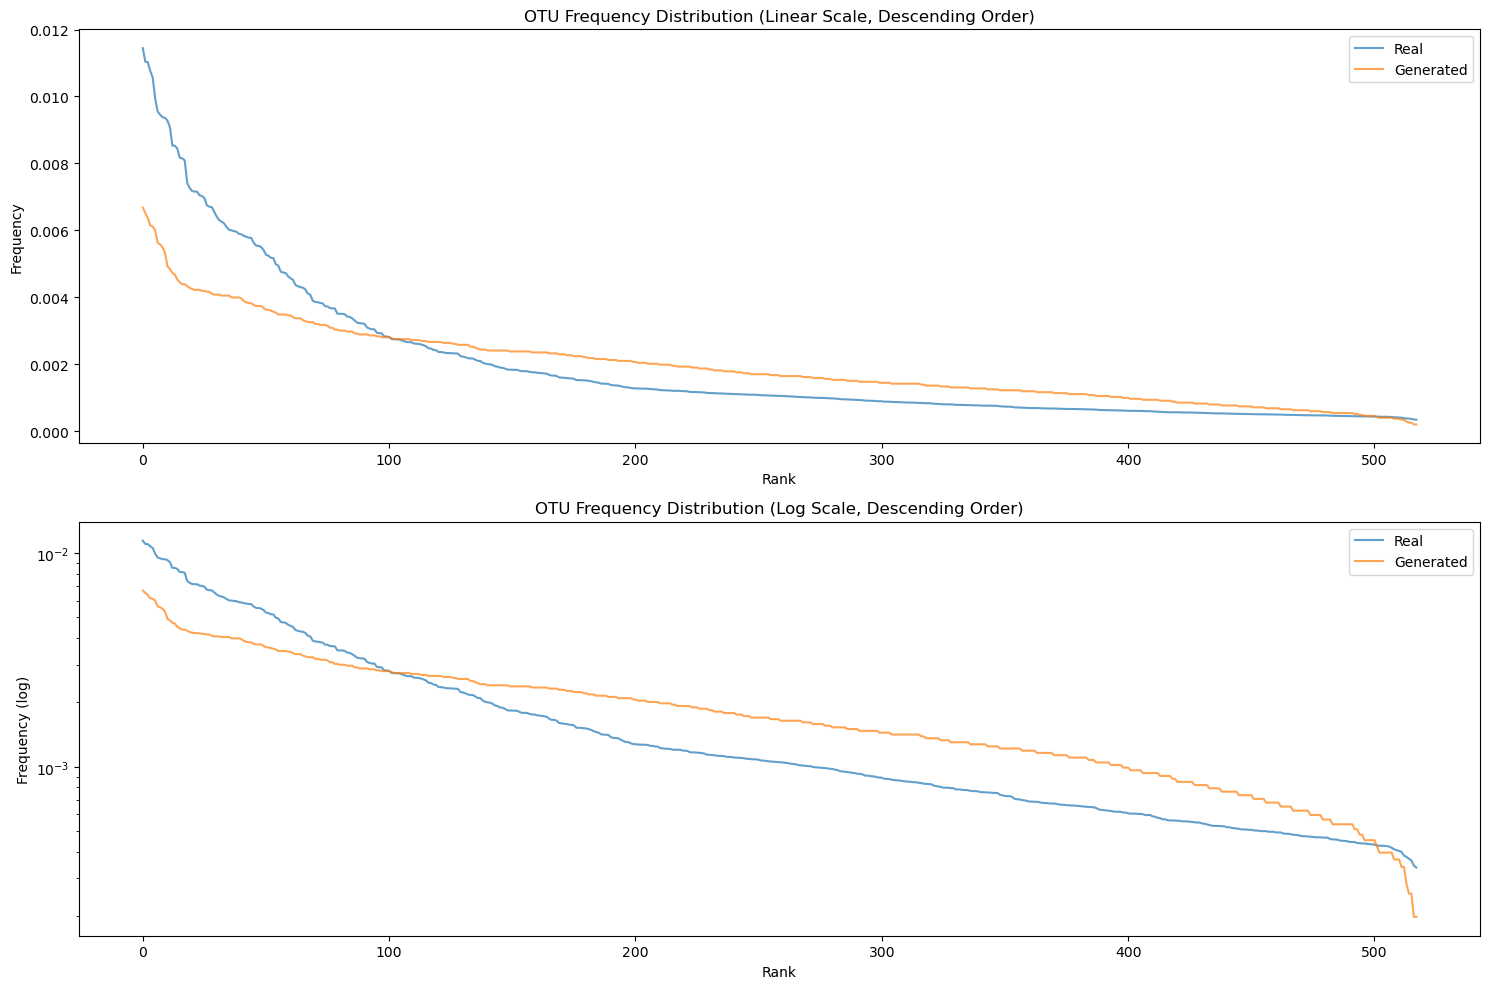

KL Divergence: 0.1709
Jensen-Shannon Divergence: 0.1880
Pearson Correlation: 0.8113

Top 20 most frequent OTUs:
Real vs Generated (OTU_ID: frequency)
Real: 206: 0.0114 | Generated: 206: 0.0067
Real: 155: 0.0110 | Generated: 147: 0.0065
Real: 147: 0.0110 | Generated: 30: 0.0064
Real: 30: 0.0108 | Generated: 90: 0.0061
Real: 207: 0.0106 | Generated: 155: 0.0061
Real: 117: 0.0099 | Generated: 193: 0.0060
Real: 203: 0.0096 | Generated: 207: 0.0056
Real: 80: 0.0095 | Generated: 117: 0.0056
Real: 99: 0.0094 | Generated: 203: 0.0055
Real: 186: 0.0094 | Generated: 99: 0.0053
Real: 193: 0.0093 | Generated: 80: 0.0049
Real: 90: 0.0091 | Generated: 22: 0.0048
Real: 278: 0.0085 | Generated: 246: 0.0047
Real: 93: 0.0085 | Generated: 104: 0.0047
Real: 140: 0.0084 | Generated: 234: 0.0045
Real: 246: 0.0082 | Generated: 140: 0.0044
Real: 58: 0.0081 | Generated: 68: 0.0044
Real: 104: 0.0081 | Generated: 201: 0.0044
Real: 132: 0.0074 | Generated: 286: 0.0043
Real: 291: 0.0073 | Generated: 186: 0.0043

D

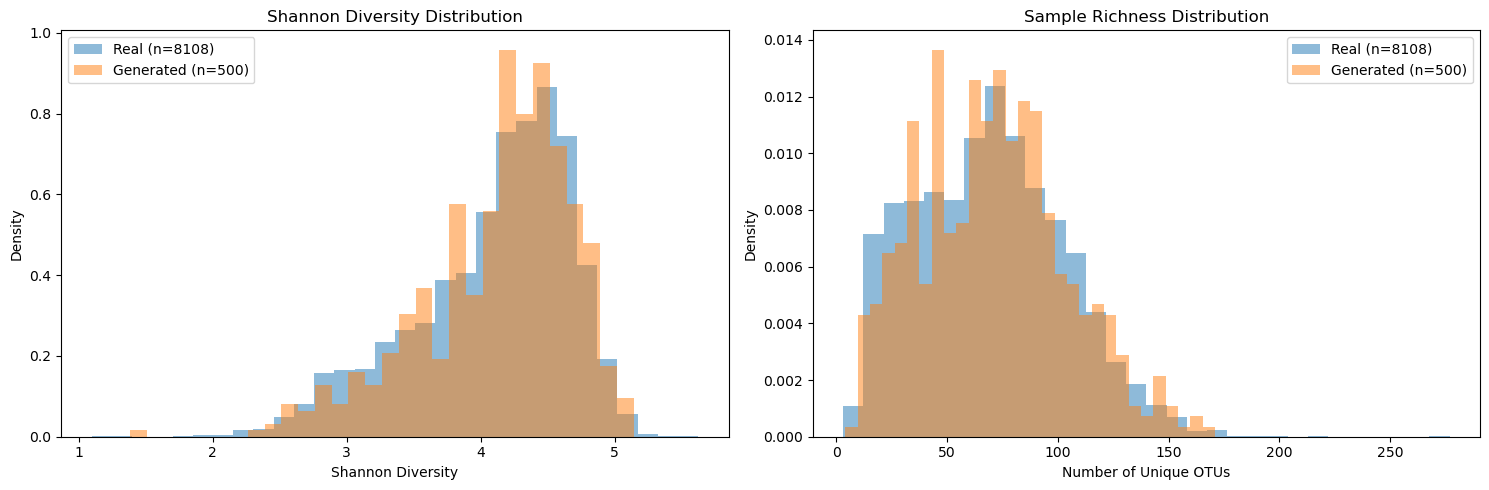

In [145]:
# Analyze distributions
vocab_size = max(max(x) for x in loaded_df['otu_arrays']) + 1
analyze_otu_distributions(loaded_df, generated_sequences, vocab_size)

In [25]:
def extended_microbiome_analysis(real_data_df, generated_sequences, num_otus):
    """Additional ecological analyses for microbiome data"""
    
    # Convert samples to presence/absence matrices
    def create_presence_matrix(samples, num_otus):
        matrix = np.zeros((len(samples), num_otus-1))  # -1 to exclude padding
        for i, sample in enumerate(samples):
            unique_otus = set(otu for otu in sample if otu != 0)
            for otu in unique_otus:
                matrix[i, otu-1] = 1
        return matrix
    
    # Get the most frequent OTUs
    def get_top_otus(samples, n=200):
        all_otus = []
        for sample in samples:
            all_otus.extend([x for x in sample if x != 0])
        counts = Counter(all_otus)
        return [otu-1 for otu, _ in counts.most_common(n)]  # -1 for zero-based indexing
    
    real_samples = [np.array([x for x in seq if x != 0]) for seq in real_data_df['otu_arrays']]
    gen_samples = [np.array([x for x in seq if x != 0]) for seq in generated_sequences]
    
    real_matrix = create_presence_matrix(real_samples, num_otus)
    gen_matrix = create_presence_matrix(gen_samples, num_otus)
    
    # Co-occurrence patterns
    real_coocur = np.corrcoef(real_matrix.T)
    gen_coocur = np.corrcoef(gen_matrix.T)
    
    # Get top OTUs indices
    top_otus = get_top_otus(real_samples)
    
    # Plot co-occurrence heatmaps
    plt.figure(figsize=(20, 8))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(real_coocur[top_otus][:, top_otus], cmap='RdBu_r', center=0)
    plt.title('Real Data Co-occurrence (top 50 most frequent OTUs)')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(gen_coocur[top_otus][:, top_otus], cmap='RdBu_r', center=0)
    plt.title('Generated Data Co-occurrence (top 50 most frequent OTUs)')
    
    plt.tight_layout()
    plt.show()
    
    # Rank-abundance curves
    def get_rank_abundance(samples):
        all_otus = []
        for sample in samples:
            unique_otus = set(otu for otu in sample if otu != 0)
            all_otus.extend(unique_otus)
        counts = Counter(all_otus)
        abundances = sorted(counts.values(), reverse=True)
        return np.array(abundances) / sum(abundances)
    
    real_abundance = get_rank_abundance(real_samples)
    gen_abundance = get_rank_abundance(gen_samples)
    
    plt.figure(figsize=(10, 6))
    plt.semilogy(real_abundance, 'b-', label='Real', alpha=0.7)
    plt.semilogy(gen_abundance, 'r-', label='Generated', alpha=0.7)
    plt.xlabel('Rank')
    plt.ylabel('Relative Abundance (log scale)')
    plt.title('Rank-Abundance Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calculate and print co-occurrence similarity for top OTUs
    top_real_coocur = real_coocur[top_otus][:, top_otus]
    top_gen_coocur = gen_coocur[top_otus][:, top_otus]
    mask = ~np.isnan(top_real_coocur) & ~np.isnan(top_gen_coocur)
    coocur_correlation = np.corrcoef(top_real_coocur[mask], top_gen_coocur[mask])[0,1]
    print(f"\nCo-occurrence Pattern Correlation (top 50 OTUs): {coocur_correlation:.3f}")
    
    # Add Bray-Curtis dissimilarity
    def bray_curtis_dissimilarity(sample1, sample2):
        shared_otus = set(sample1).intersection(set(sample2))
        total_otus = set(sample1).union(set(sample2))
        if not total_otus:
            return 0
        return 1 - (2 * len(shared_otus)) / (len(set(sample1)) + len(set(sample2)))
    
    # Calculate average Bray-Curtis within each dataset
    def mean_bray_curtis(samples, max_pairs=1000):
        n = len(samples)
        pairs = min(max_pairs, n * (n-1) // 2)
        dissimilarities = []
        
        for _ in range(pairs):
            i, j = np.random.choice(n, 2, replace=False)
            bc = bray_curtis_dissimilarity(samples[i], samples[j])
            dissimilarities.append(bc)
            
        return np.mean(dissimilarities)
    
    real_bc = mean_bray_curtis(real_samples)
    gen_bc = mean_bray_curtis(gen_samples)
    
    print(f"\nMean Bray-Curtis Dissimilarity:")
    print(f"Real samples: {real_bc:.3f}")
    print(f"Generated samples: {gen_bc:.3f}")
    
def calculate_cooccurrence_correlation(sequences, num_otus, reference_coocur=None):
    """Calculate co-occurrence correlation for a set of sequences"""
    # Create presence/absence matrix
    matrix = np.zeros((len(sequences), num_otus-1))
    for i, seq in enumerate(sequences):
        unique_otus = set(otu for otu in seq if otu != 0)
        for otu in unique_otus:
            matrix[i, otu-1] = 1
    
    # Calculate co-occurrence
    coocur = np.corrcoef(matrix.T)
    
    # Get top OTUs
    all_otus = []
    for seq in sequences:
        all_otus.extend([x for x in seq if x != 0])
    counts = Counter(all_otus)
    top_otus = [otu-1 for otu, _ in counts.most_common(50)]
    
    # If reference provided, calculate correlation
    if reference_coocur is not None:
        top_coocur = coocur[top_otus][:, top_otus]
        top_ref_coocur = reference_coocur[top_otus][:, top_otus]
        
        # Flatten matrices and calculate correlation directly
        correlation = np.corrcoef(top_coocur.flatten(), top_ref_coocur.flatten())[0,1]
        return correlation
    
    return coocur

def extended_microbiome_analysis(real_data_df, generated_sequences, num_otus):
    real_samples = [np.array([x for x in seq if x != 0]) for seq in real_data_df['otu_arrays']]
    gen_samples = [np.array([x for x in seq if x != 0]) for seq in generated_sequences]
    
    # Get top OTUs
    all_otus = []
    for seq in real_samples:
        all_otus.extend([x for x in seq if x != 0])
    counts = Counter(all_otus)
    top_otus = [otu-1 for otu, _ in counts.most_common(200)]
    
    # Calculate full co-occurrence matrices
    real_coocur = calculate_cooccurrence_correlation(real_samples, num_otus)
    gen_coocur = calculate_cooccurrence_correlation(gen_samples, num_otus)
    
    # Calculate correlation score
    correlation = calculate_cooccurrence_correlation(gen_samples, num_otus, real_coocur)
    
    # Calculate RMSD for top OTUs
    real_subset = real_coocur[top_otus][:, top_otus]
    gen_subset = gen_coocur[top_otus][:, top_otus]
    rmsd = np.sqrt(np.mean((real_subset - gen_subset)**2))
    
    # Plot heatmaps
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    sns.heatmap(real_coocur[top_otus][:, top_otus], cmap='RdBu_r', center=0)
    plt.title('Real Data Co-occurrence (top 50 OTUs)')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(gen_coocur[top_otus][:, top_otus], cmap='RdBu_r', center=0)
    plt.title('Generated Data Co-occurrence (top 50 OTUs)')
    plt.tight_layout()
    plt.show()
    
    print(f"\nCo-occurrence Correlation: {correlation:.3f}")
    print(f"RMSD between matrices: {rmsd:.3f}")

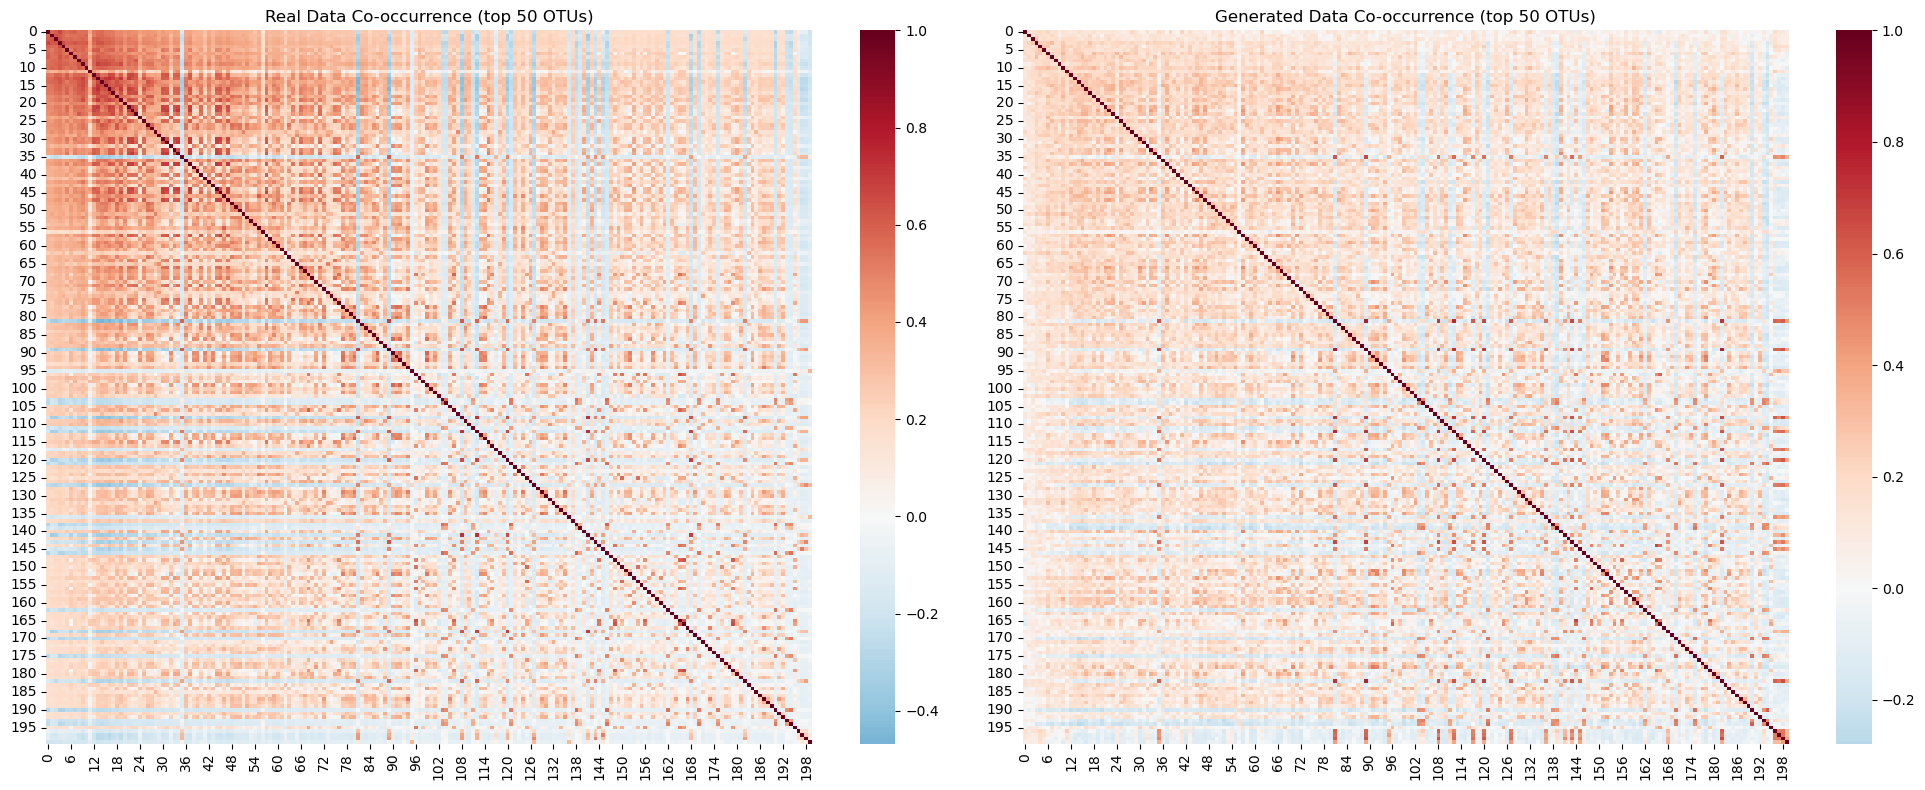


Co-occurrence Correlation: 0.829
RMSD between matrices: 0.125


In [146]:
extended_microbiome_analysis(loaded_df, generated_sequences, vocab_size) #allowing longer run time may be the main factor in this...?

In [148]:
generated_sequences[100]

array([200, 152,  73,  28,  72, 401, 363, 151,  15,  34, 102, 348, 101,
       441, 406,  33,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0])

2.79 had 0.630, 2.65 had 0.667, 2.61 had 0.597: so i have learned that the smaller model is probably lowering loss by doing well across the averaged batch by just recovering well otu frequencies independantly. but the deeper model is actually trying to model co-occurences.

In [132]:
def analyze_final_logits(model, num_sequences=100, num_steps=100, device='cpu'):
    model = model.to(device)
    model.eval()
    
    # Get real lengths for sampling
    real_lengths = [len(x) for x in loaded_df['otu_arrays']]
    sampled_lengths = np.random.choice(real_lengths, size=num_sequences)
    max_sampled_length = max(sampled_lengths)
    sampled_lengths = torch.tensor(sampled_lengths, device=device)

    with torch.no_grad():
        # Get warped timesteps
        uniform_steps = torch.linspace(1, 0, num_steps).to(device)
        timesteps = model.time_warping.warp_time(uniform_steps)
        
        # Initialize with scaled noise

        torch.manual_seed(42)
        sigma_T = torch.sqrt(timesteps[0])
        xt = sigma_T * torch.randn(num_sequences, max_sampled_length, model.embed_dim).to(device)
        
        # Create mask
        mask = torch.zeros(num_sequences, max_sampled_length, dtype=torch.bool, device=device)
        for i, length in enumerate(sampled_lengths):
            mask[i, length:] = True
        
        print("\nRunning diffusion...")
        for i in tqdm(range(len(timesteps) - 1)):
            t = timesteps[i]
            t_next = timesteps[i + 1]
            
            t_batch = t.expand(num_sequences)
            logits = model(xt, mask, t_batch)
            expected_x0 = model.get_expected_embedding(logits)
            
            if t > t_next:
                score = model.calculate_score(xt, expected_x0, t_batch)
                dt = t_next - t
                xt = xt - t * score * dt
                
                # Add scaled noise (new addition)
                noise_scale = 1  # Reduced noise magnitude
                sigma = torch.sqrt(t_next) * noise_scale
                noise = torch.randn_like(xt, device=device)
                xt = xt + sigma * noise
            
            # Final prediction
        final_logits = model(xt, mask, torch.zeros(num_sequences, device=device))
    
        total_entropy = 0
        total_positions = 0
        
        for seq_idx in range(min(3, num_sequences)):
            print(f"\nSequence {seq_idx + 1} (length {sampled_lengths[seq_idx]}):")
            for pos in range(min(5, sampled_lengths[seq_idx])):
                logits = final_logits[seq_idx, pos]
                logits[0] = float('-inf')
                probs = F.softmax(logits, dim=-1)
                
                top_probs, top_indices = torch.topk(probs, 5)
                print(f"\nPosition {pos}:")
                print("Top 5 predictions (OTU: probability):")
                for idx, prob in zip(top_indices, top_probs):
                    print(f"OTU {idx.item()}: {prob.item():.4f}")
                
                entropy = -torch.sum(probs * torch.log2(probs + 1e-10))
                print(f"Distribution entropy (bits): {entropy.item():.4f}")
                
                total_entropy += entropy.item()
                total_positions += 1
        
        print(f"\nAverage entropy across first 5 positions: {total_entropy/total_positions:.4f} bits")

        return total_entropy/total_positions

# Run analysis
avg_entropy = analyze_final_logits(model0, num_sequences=200, num_steps=80, device='cuda')





Running diffusion...


100%|██████████| 79/79 [00:00<00:00, 156.97it/s]


Sequence 1 (length 85):

Position 0:
Top 5 predictions (OTU: probability):
OTU 90: 1.0000
OTU 127: 0.0000
OTU 40: 0.0000
OTU 452: 0.0000
OTU 156: 0.0000
Distribution entropy (bits): 0.0000

Position 1:
Top 5 predictions (OTU: probability):
OTU 203: 1.0000
OTU 426: 0.0000
OTU 455: 0.0000
OTU 429: 0.0000
OTU 315: 0.0000
Distribution entropy (bits): 0.0000

Position 2:
Top 5 predictions (OTU: probability):
OTU 263: 0.8568
OTU 471: 0.0446
OTU 359: 0.0211
OTU 400: 0.0098
OTU 438: 0.0076
Distribution entropy (bits): 1.1572

Position 3:
Top 5 predictions (OTU: probability):
OTU 366: 0.7600
OTU 213: 0.2374
OTU 373: 0.0012
OTU 164: 0.0004
OTU 479: 0.0002
Distribution entropy (bits): 0.8239

Position 4:
Top 5 predictions (OTU: probability):
OTU 369: 1.0000
OTU 371: 0.0000
OTU 331: 0.0000
OTU 500: 0.0000
OTU 379: 0.0000
Distribution entropy (bits): 0.0000

Sequence 2 (length 56):

Position 0:
Top 5 predictions (OTU: probability):
OTU 250: 1.0000
OTU 213: 0.0000
OTU 457: 0.0000
OTU 328: 0.0000
OT

In [131]:
def analyze_step_impact(model, step_counts=[1,2,3,4,5,6,7,8,9,10], num_sequences=20, device='cpu'):
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    model = model.to(device)
    results = {}
    
    # Run diffusion with different step counts
    for num_steps in step_counts:
        model.eval()
        
        # Get real lengths for sampling
        real_lengths = [len(x) for x in loaded_df['otu_arrays']]
        sampled_lengths = np.random.choice(real_lengths, size=num_sequences)
        max_sampled_length = max(sampled_lengths)
        sampled_lengths = torch.tensor(sampled_lengths, device=device)

        with torch.no_grad():
            # Get warped timesteps
            uniform_steps = torch.linspace(1, 0, num_steps).to(device)
            timesteps = model.time_warping.warp_time(uniform_steps)
            
            # Initialize with scaled noise
            torch.manual_seed(42)
            sigma_T = torch.sqrt(timesteps[0])
            xt = sigma_T * torch.randn(num_sequences, max_sampled_length, model.embed_dim).to(device)
            
            # Create mask
            mask = torch.zeros(num_sequences, max_sampled_length, dtype=torch.bool, device=device)
            for i, length in enumerate(sampled_lengths):
                mask[i, length:] = True
            
            print("\nRunning diffusion...")
            for i in tqdm(range(len(timesteps) - 1)):
                t = timesteps[i]
                t_next = timesteps[i + 1]
                
                t_batch = t.expand(num_sequences)
                logits = model(xt, mask, t_batch)
                expected_x0 = model.get_expected_embedding(logits)
                
                if t > t_next:
                    score = model.calculate_score(xt, expected_x0, t_batch)
                    dt = t_next - t
                    xt = xt - t * score * dt
                    
                    # Add scaled noise (new addition)
                    noise_scale = 1  # Reduced noise magnitude
                    sigma = torch.sqrt(t_next) * noise_scale
                    noise = torch.randn_like(xt, device=device)
                    xt = xt + sigma * noise
                
                # Final prediction
            final_logits = model(xt, mask, torch.zeros(num_sequences, device=device))
                
                # Store results
            results[num_steps] = {
                    'entropies': [],
                    'top_probs': []
                }
                
            # Calculate metrics for each sequence
            for seq_idx in range(num_sequences):
                for pos in range(min(5, sampled_lengths[seq_idx])):
                    logits = final_logits[seq_idx, pos]
                    logits[0] = float('-inf')  # mask padding token
                    probs = F.softmax(logits, dim=-1)
                    
                    # Calculate entropy
                    entropy = -torch.sum(probs * torch.log2(probs + 1e-10))
                    results[num_steps]['entropies'].append(entropy.item())
                    
                    # Get top probability
                    top_prob = torch.max(probs).item()
                    results[num_steps]['top_probs'].append(top_prob)

    # Create plotly figure
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Distribution Entropy vs Steps', 'Top Prediction Probability vs Steps'),
        horizontal_spacing=0.1
    )

    # Add box plots for entropy and top probabilities
    for step in step_counts:
        fig.add_trace(
            go.Box(
                y=[val for val in results[step]['entropies']],
                name=str(step),
                boxpoints='outliers',
                line_color='blue'
            ),
            row=1, col=1
        )
        
        fig.add_trace(
            go.Box(
                y=[val for val in results[step]['top_probs']],
                name=str(step),
                boxpoints='outliers',
                line_color='red'
            ),
            row=1, col=2
        )

    # Update layout
    fig.update_layout(
        title_text="Impact of Diffusion Steps on Prediction Characteristics",
        showlegend=False,
        width=1200,
        height=600,
        template='plotly_white'
    )

    fig.update_xaxes(title_text="Number of Steps", row=1, col=1)
    fig.update_xaxes(title_text="Number of Steps", row=1, col=2)
    fig.update_yaxes(title_text="Distribution Entropy (bits)", row=1, col=1)
    fig.update_yaxes(title_text="Top Prediction Probability", row=1, col=2)

    # Show the plot
    fig.show()

    # Print summary statistics
    print("\nSummary Statistics:")
    for steps in step_counts:
        mean_entropy = np.mean(results[steps]['entropies'])
        mean_prob = np.mean(results[steps]['top_probs'])
        print(f"\nSteps: {steps}")
        print(f"Average Entropy: {mean_entropy:.4f} bits")
        print(f"Average Top Probability: {mean_prob:.4f}")

    return results, fig

# Run analysis
results, fig = analyze_step_impact(model0, step_counts=[1,2,3,4,5,6,7,8, 9,10,20, 40,80], num_sequences=100, device='cuda')


Running diffusion...


0it [00:00, ?it/s]



Running diffusion...


100%|██████████| 1/1 [00:00<00:00, 222.54it/s]



Running diffusion...


100%|██████████| 2/2 [00:00<00:00, 236.87it/s]



Running diffusion...


100%|██████████| 3/3 [00:00<00:00, 245.55it/s]



Running diffusion...


100%|██████████| 4/4 [00:00<00:00, 246.29it/s]



Running diffusion...


100%|██████████| 5/5 [00:00<00:00, 244.84it/s]



Running diffusion...


100%|██████████| 6/6 [00:00<00:00, 259.84it/s]



Running diffusion...


100%|██████████| 7/7 [00:00<00:00, 263.31it/s]



Running diffusion...


100%|██████████| 8/8 [00:00<00:00, 262.29it/s]



Running diffusion...


100%|██████████| 9/9 [00:00<00:00, 249.78it/s]



Running diffusion...


100%|██████████| 19/19 [00:00<00:00, 258.25it/s]



Running diffusion...


100%|██████████| 39/39 [00:00<00:00, 255.54it/s]



Running diffusion...


100%|██████████| 79/79 [00:00<00:00, 255.95it/s]



Summary Statistics:

Steps: 1
Average Entropy: 6.4999 bits
Average Top Probability: 0.1153

Steps: 2
Average Entropy: 5.3821 bits
Average Top Probability: 0.1779

Steps: 3
Average Entropy: 5.0372 bits
Average Top Probability: 0.2329

Steps: 4
Average Entropy: 4.4927 bits
Average Top Probability: 0.3152

Steps: 5
Average Entropy: 3.8184 bits
Average Top Probability: 0.4096

Steps: 6
Average Entropy: 3.4751 bits
Average Top Probability: 0.4656

Steps: 7
Average Entropy: 3.2680 bits
Average Top Probability: 0.4991

Steps: 8
Average Entropy: 2.8370 bits
Average Top Probability: 0.5539

Steps: 9
Average Entropy: 2.4981 bits
Average Top Probability: 0.6028

Steps: 10
Average Entropy: 2.4955 bits
Average Top Probability: 0.6081

Steps: 20
Average Entropy: 1.2889 bits
Average Top Probability: 0.7838

Steps: 40
Average Entropy: 0.7516 bits
Average Top Probability: 0.8650

Steps: 80
Average Entropy: 0.3852 bits
Average Top Probability: 0.9242


In [142]:
generated_sequences_umap = generate_sequences(model0, num_sequences=500, temperature=1, num_steps=100)
#It seems that both num sequences and num steps together have an effect. im not sure on the combined function that imroves (could increasing one require
#increase in the other?)
"""
250,10 recovers 6-7 clusters
500,5 recovers 4
500,10 recovers 4-5
500,15 r 4
500,20 recovers 4-5
500,30 r 5 but stringy and unnatural looking, not clumpy
"""


Running diffusion...


100%|██████████| 99/99 [00:01<00:00, 74.33it/s]


'\n250,10 recovers 6-7 clusters\n500,5 recovers 4\n500,10 recovers 4-5\n500,15 r 4\n500,20 recovers 4-5\n500,30 r 5 but stringy and unnatural looking, not clumpy\n'

Converting to binary vectors...
Performing UMAP reduction...


/mnt/mnemo7/mpelus/miniconda3/envs/matlas/lib/python3.12/site-packages/umap/umap_.py:1887: UserWarning:

gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable

/mnt/mnemo7/mpelus/miniconda3/envs/matlas/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



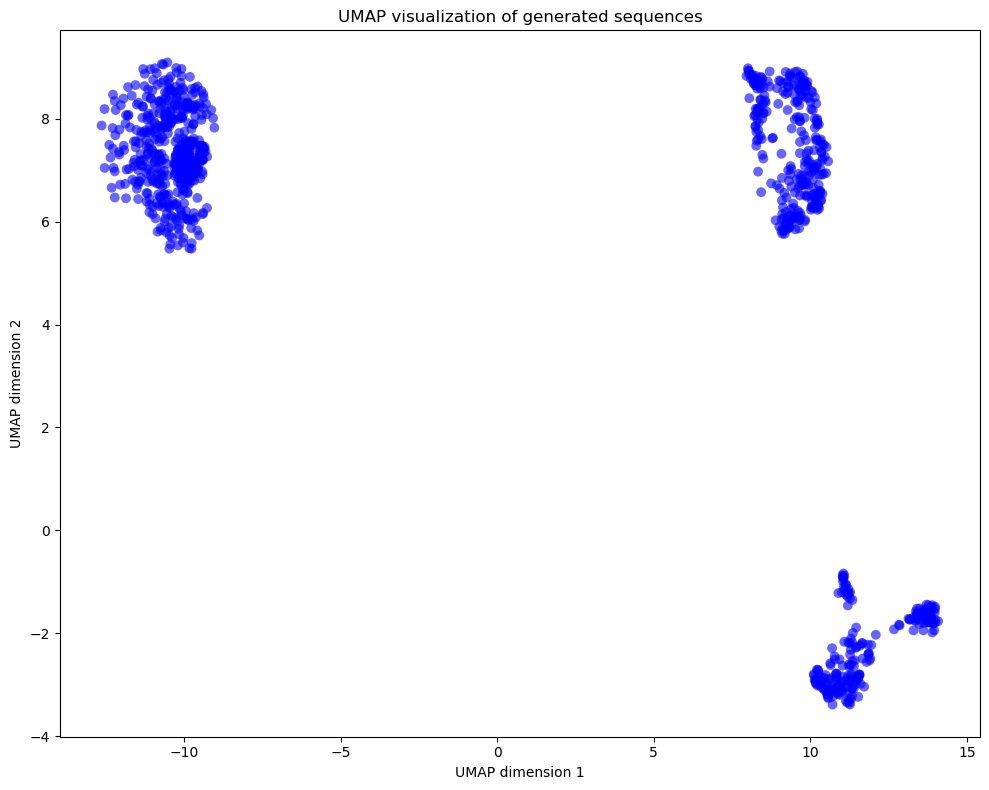


Sequence statistics:
Average sequence length: 68.13
Number of unique tokens used: 519


In [143]:
import umap
import numpy as np
np.random.seed(42)
import random
random.seed(42)

# Convert sequences to binary vectors
print("Converting to binary vectors...")

# First, determine the vocabulary size (number of unique tokens)
vocab_size = 519  # Adjust this if your vocab size is different

# Initialize array to hold binary vectors
binary_vectors = np.zeros((1000, vocab_size))

# Convert each sequence to binary vector
for i, seq in enumerate(generated_sequences_umap): #_umap
    # Create binary vector where 1 indicates presence of token
    unique_tokens = np.unique(seq[seq != 0])  # Ignore padding tokens (0)
    binary_vectors[i, unique_tokens] = 1

# Reduce dimensionality with UMAP
print("Performing UMAP reduction...")
reducer = umap.UMAP(
    n_neighbors=10,
    min_dist=0.1,
    n_components=2,
    random_state=42,
    metric = 'jaccard'
)
embedding = reducer.fit_transform(binary_vectors)

# Create scatter plot
# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], 
           alpha=0.6,           # Adjust transparency
           s=50,               # Point
           c='blue',          # Point color
           edgecolor='none')  # No edge color for cleaner look

plt.title('UMAP visualization of generated sequences')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nSequence statistics:")
print(f"Average sequence length: {np.mean([len(seq[seq != 0]) for seq in generated_sequences]):.2f}")
print(f"Number of unique tokens used: {len(np.unique(generated_sequences))}")